# Implementación dunha familia de códigos CSS-LDPC

In [23]:
import numpy as np
import random
import math
import itertools
import matplotlib.pyplot as plt
import pyldpc
import time
from typing import Dict, Tuple, List

## Condicións

Primeiro, crearemos catro funcións que se encargarán de garantizar que se cumplen as condicións:

- a) **Conmutatividade**: Os elementos $\boldsymbol{f}$ e $\boldsymbol{g}$ deben conmutar entre eles, de xeito que
    \begin{equation*}
        f_i \circ g_j (x) = g_j \circ f_i (x) \qquad \forall i, j \in\{0, \dots, L/2\}.
    \end{equation*} 
    <br /> 
    
    
- b) **Lonxitude mínima (*girth*) $2L$ no grafo de Tanner**: Para cada $0 \leq l, l' \leq L/2$ e cada $k \in \{-1, 0, 1\}$, imponse
    \begin{equation}
        f_l \circ g_{-l+k} (x) \neq f_{l'} \circ g_{-l'+k}(x),
        \label{eq:condicion_b}
    \end{equation}
    <br /> 
    
- c) **Ausencia de ciclos curtos**: Eliminar os 4-ciclos.

### Condición (a)

Sexan $f_1 (x) = a_1 x + b_1 = (a_1, b_1)$ e $g_2 = a_2 x + b_2 = (a_2, b_2)$, sen perda de xeneralidade. Entón, 
    \begin{equation*}
        (a_1, b_1) \circ (a_2, b_2) = a_1(a_2 x + b_2) + b_1 = a_1 a_2 x + a_1 b_2 + b_1 = (a_1 a_2, a_1 b_2 + b_1).
    \end{equation*}
    Analogamente,
    \begin{equation*}
        (a_2, b_2) \circ (a_1, b_1) = (a_2 a_1, a_2 b_1 + b_2).
    \end{equation*}
    Pola conmutatividade do anel $\mathbb{Z}_P$, sempre se cumpre $a_1 a_2 = a_2 a_1$, polo que solo resta igualar
    \begin{equation*}
        a_1 b_2 + b_1 \equiv a_2 b_1 + b_2 \mod P.
    \end{equation*}

In [8]:
def condition_a(P, f_array, g_array):
    
    '''
    P (int) - modulo das matrices de permutación
    f_array (list) - vector de funcións f, descritas como tuplas [(a,b), (c,d), ...]
    g_array (list) - vector de funcións g, descritas como tuplas [(a,b), (c,d), ...]
    
    '''
    
    for f in f_array:
        a_1 = f[0]
        b_1 = f[1]
        
        for g in g_array:
            a_2 = g[0]
            b_2 = g[1]
        
            # Comprobación da condición (a)
            
            if int((a_1*b_2+b_1) % P) == int((a_2*b_1+b_2) % P):
                # se se cumple, pasamos ao seguinte par de funcións
                continue
            else:
                # se se rompe, retorna False
                return(False)
    
    # retorna True se non se rompeu a condición en ningún caso
    return(True)

### Condición (b)

Reescribindo a ecuación en función dos parámetros $a$ e $b$
    \begin{align*}
        f_l \circ g_{-l+k} (x) = a_l (a_{-l+k} x + b_{-l+k} ) + b_l = (a_l a_{-l + k}, a_l b_{-l+k} + b_l),
    \end{align*}
    agora é preciso garantir ambas partes do par, polo tanto
    \begin{align*}
        a_l a_{-l + k} &\equiv a_{l'} a_{-l' + k}, \mod P\\
        a_l b_{-l+k} + b_l &\equiv a_{l'} b_{-l'+k} + b_{l'}  \mod P.
    \end{align*}

Esta condición é necesaria para que haxa un ciclo de lonxitude $2L$ no grafo de Tanner.

In [9]:
def condition_b(P, L, f_array, g_array):
    '''
    P (int) - modulo das matrices de permutación
    L (int) - pero por filas da matriz H
    f_array (list) - vector de funcións f, descritas como tuplas [(a,b), (c,d), ...]
    g_array (list) - vector de funcións g, descritas como tuplas [(a,b), (c,d), ...]
    
    '''
    
    # Tomamos os subíndices l e l' da ecuación
    
    for l1 in range(len(f_array)):
        for l2 in range(len(f_array)):
            
            # Recorremos k
            for k in [-1, 0, 1]:
                
                # Asociamos os elementos de cada par de funcións
                a_l1 = f_array[l1][0]
                b_l1 = f_array[l1][1]
                
                subscript_g1 = int((-l1+k)%(L/2))
                a_g1 = g_array[subscript_g1][0]
                b_g1 = g_array[subscript_g1][1]
                
                a_l2 = f_array[l2][0]
                b_l2 = f_array[l2][1]
                
                subscript_g2 = int((-l2+k)%(L/2))
                a_g2 = g_array[subscript_g2][0]
                b_g2 = g_array[subscript_g2][1]
                
                # Saltámonos o caso de comparar elementos iguais
                if l1 == l2 and subscript_g1 == subscript_g2:
                    continue
                    
                # Establecemos as condicións a comprobar
                
                check_1 = int((a_l1*a_g1 - a_l2*a_g2)%P)
                check_2 = int((a_l1*b_g1 + b_l1 - a_l2*b_g2 - b_l2)%P)
                
                if check_1 != 0 or check_2 != 0:
                    # Se non se rompe (b), continuamos
                    continue
                    
                else:
                    # Se se rompe (b), retorna False
                    return(False)
         
    # Devolve True se non se atoparon discrepancias
    return(True) 

### Condición (c)

Buscamos, para cada columna $c_1$ o elemento $(f_1(c_1), c_1)$. Necesariamente, existirá unha fila na columna $c_3 = c_1$ que teña un 1, por tanto $(f_0(c_3), c_3) = (f_0(c_1), c_1)$. Do mesmo xeito, existirá unha columna $c_2$ para a cal coincidan as filas $f_1(c_1) = g_1(c_2)$. Esta condición é un pouco máis delicada pois precisa da resolución dunha ecuación modular.
    \begin{equation*}
        f_1(c_1) = a_1 c_1 + b_1 \equiv a_2 c_2 + b_2 = g_1(c_2) \mod{P}
    \end{equation*}
    Queremos atopar $c_2$, polo que despexando obtemos
    \begin{equation*}
        a_2 c_2 \equiv a_1 c_1 - b_2 \mod P
    \end{equation*}
    ou, equivalentemente,
    \begin{equation*}
        c_2 \equiv (a_2)^{-1} (a_1 c_1 - b_2) \mod P.
    \end{equation*}
    A ecuación pasa por calcular a inversa de $a_2$ módulo $P$, que só existe cando $a_2$ e $P$ son coprimos, é dicir,
    \begin{equation*}
        \text{mcd}(a_2, P) = 1.
    \end{equation*}
    Discutiremos a natureza de $P$ nos seguintes parágrafos, pero polo de agora, imos supoñer que esta condición se cumpre e $a_2$ e $P$ sempre son coprimos. Logo, podemos obter $c_2$ e, unha vez feito isto, xa só queda establecer $c_4 = c_2$ e obteremos o elemento cuarto 
    \begin{equation*}
        (g_0(c_4), c_4) = (g_0(c_2), c_2) = (f_0(c_3), c_2) = (f_0(c_1), c_2)
    \end{equation*}
    Entón, existe un 4-ciclo se e só se
    \begin{equation}
        g_0(c_2) \equiv f_0(c_1) \mod P.
        \label{eq:condicion_c}
    \end{equation}

In [10]:
# Precisamos unha función para a matriz Hx e outra para Hz pola súa estrutura diferente

def condition_c_Hx(P, f_array, g_array):
    
    """
    P (int) - modulo das matrices de permutación
    f_array (list) - vector de funcións f, descritas como tuplas [(a,b), (c,d), ...]
    g_array (list) - vector de funcións g, descritas como tuplas [(a,b), (c,d), ...]
    
    """
    
    # Creamos os arrays que ordenarán as funcións f e g segundo a disposición de Hx
    
    # primeira fila
    all_array_first = f_array + g_array
    
    # segunda fila
    last_f = f_array[-1]
    
    f_short = f_array.copy()
    f_short.pop(-1)
    f_second = [last_f] + f_short
    
    last_g = g_array[-1]
    g_short = g_array.copy()
    g_short.pop()
    g_second = [last_g] + g_short
    
    all_array_second = f_second + g_second
    
    # lista de índices    
    index_list = [i for i in range(len(all_array_first))]
    
    for i, j in itertools.permutations(index_list, 2):
        
        # asignamos matrices auxiliares para cada elemento do 4-ciclo
        
        h1 = all_array_first[i]
        h2 = all_array_first[j]
        h3 = all_array_second[i]
        h4 = all_array_second[j]
        
        for c in range(P):

            a_2_inv = pow(h2[0], -1, P)   # calcula a inversa de a_2 modulo P
            c_2 = int(((h1[0]*c + h1[1] - h2[1])*a_2_inv) % P)

            # Comproba a condición do 4-ciclo
            
            check = int((h3[0]*c + h3[1] - h4[0]*c_2 - h4[1]) % P)

            if check == 0:
                
                # Se hai 4-ciclos, devolve False
                return(False)
    
    # Se non atopou 4-ciclos, devolve True
    return(True)
    

In [11]:
# Análogo para Hz en distinta disposición

def condition_c_Hz(P, f_array, g_array):
    
    """
    P (int) - modulo das matrices de permutación
    f_array (list) - vector de funcións f, descritas como tuplas [(a,b), (c,d), ...]
    g_array (list) - vector de funcións g, descritas como tuplas [(a,b), (c,d), ...]
    
    """
    
    # Créase a ordenación da primeira e segunda fila trasposta (primeira e segunda columna)
    
    n = len(f_array)
    
    all_array_first = [g_array[0]] + g_array[:0:-1] + [f_array[0]] + f_array[:0:-1]
    
    all_array_second = [g_array[1]] + [g_array[0]] + g_array[:1:-1] + [f_array[1]] + [f_array[0]] + f_array[:1:-1]
    
    index_list = [i for i in range(len(all_array_first))]
    
    # Compróbase a condición por columnas en lugar de por filas, é dicir, Hz^T
    
    for i, j in itertools.permutations(index_list, 2):
        
        h1 = all_array_first[i]
        h2 = all_array_second[i]
        h3 = all_array_first[j]
        h4 = all_array_second[j]
        
        for c in range(P):
            
            a_2_inv = pow(h2[0], -1, P)   # calcula a inversa de a_2 módulo P
            c_2 = int(((h1[0]*c + h1[1] - h2[1])*a_2_inv) % P)

            check = int((h3[0]*c + h3[1] - h4[0]*c_2 - h4[1]) % P)

            if check == 0:
                return(False)
            
    return(True)

Coa función principal, comenzamos explorando todos os posibles valores de $f_0$ e $g_0$ e imos engadindo funcións a $\boldsymbol{f}$ e $\boldsymbol{g}$ que vaian cumplindo as condicións (a), (b) e (c) sucesivamente. O algoritmo remata cando se atopou o primeiro conxunto de funcións que as cumplan, nun afán de reducir a carga computacional do método.

In [12]:
def main(P, L, f_0, g_0):
    
    """
    P (int) - modulo das matrices de permutación
    L (int) - peso por filas ou cantidade de matrices de permutación por fila
    f_0 (tuple) - tupla inicial para o vector f_array
    g_0 (tuple) - tupla inicial para o vector g_array 
    """
    
    # Número de funcións en cada array f e g (L/2)
    
    number_of_polynomials = int(L/2-1)
    
    # Inicializamos a lista de funcións coas tuplas dadas
    
    f_array = [f_0]
    g_array = [g_0]
    
    for i in range(number_of_polynomials):
        # Recorremos todos os valores de a e b para f
        for a in range(1, P):
            for b in range(0, P):
                
                # Evitamos que no mesmo conxunto haxa funcións repetidas ou a matriz unidade
                
                if (a,b) in f_array or (a,b) == (1,0):
                    continue
                elif condition_a(P, g_array, [(a,b)]) == True:
                    
                    # gardamos f como posible candidata 
                    # só se conmuta con todas as funcións de g
                    f_array.append((a,b))
                    
                    for c in range(1, P):
                        for d in range(0, P):
                            
                            # recorremos todos os valores de c e d para g
                            
                            if (c,d) in g_array or (c,d) == (1,0):
                                continue
                            elif condition_a(P, f_array, [(c,d)]) == True:
                                
                                # gardamos g só se conmuta con f_array
                                g_array.append((c,d))
                                
                                # comprobamos que f_array e g_array cumplen as condicións (b) e (c)
                                
                                conditionb = condition_b(P, 2*len(f_array), f_array, g_array)
                                conditionc1 = condition_c_Hx(P, f_array, g_array)
                                conditionc2 = condition_c_Hz(P, f_array, g_array)
                                
                                if conditionb == True and conditionc1 == True and conditionc2 == True:
                                    # se cumplen a condición, rompemos o bucle e buscamos a seguinte función
                                    break  
                                else:
                                    # se non as cumplen, eliminamos g como candidata
                                    g_array.pop(-1)
                        else:
                            continue
                        break
                        
                    if len(g_array) == len(f_array):
                        break      
                    else:
                        # eliminamos f como candidata
                        f_array.pop(-1)
                        continue
            else:
                continue  # Continua se o bucle interior non foi roto
            break 
                
    return(f_array, g_array)

Comprobamos que as funcións proporcionadas polos autores orixinais do método cumpren as tres condicións (a), (b), (c) para saber se están ben implementadas.

In [13]:
print(condition_a(9, [(1,8), (7,7)], [(1,3), (1,6)]))
print(condition_a(9, [(1,1), (1,7)], [(1,1), (1,5)]))
print(condition_a(6300, [(1051,2795), (4201,225), (1051,110), (2101, 1675)], [(5041,1122), (5041,4350), (3781, 1686), (2521, 2298)]))

True
True
True


In [14]:
print(condition_b(9, 4, [(1,8), (7,7)], [(1,3), (1,6)]))
print(condition_b(9, 4, [(1,1), (1,7)], [(1,1), (1,5)]))
print(condition_b(6300, 4, [(1051,2795), (4201,225), (1051,110), (2101, 1675)], [(5041,1122), (5041,4350), (3781, 1686), (2521, 2298)]))

True
True
True


In [15]:
print(condition_c_Hx(9, [(1,8), (7,7)], [(1,3), (1,6)]))
print(condition_c_Hx(9, [(1,1), (1,7)], [(1,1), (1,5)]))
print(condition_c_Hx(6300, [(1051,2795), (4201,225), (1051,110), (2101, 1675)], [(5041,1122), (5041,4350), (3781, 1686), (2521, 2298)]))

True
True
True


In [16]:
print(condition_c_Hz(9, [(1,8), (7,7)], [(1,3), (1,6)]))
print(condition_c_Hz(9, [(1,1), (1,7)], [(1,1), (1,5)]))
print(condition_c_Hz(6300, [(1051,2795), (4201,225), (1051,110), (2101, 1675)], [(5041,1122), (5041,4350), (3781, 1686), (2521, 2298)]))

True
True
True


## Construción das matrices $H_x$ e $H_z$

Lembremos a estrutura destas matrices de paridade.

\begin{align}
H_X &= \left(\begin{array}{cccc|ccccc}
        F_0 & F_1 & \dots & F_{L/2-1}       & G_0 & G_1 & \dots & G_{L/2}-1 \\
        F_{L/2-1} & F_0 & \dots & F_{L/2-2} & G_{L/2-1} & G_0 & \dots & G_{L/2-2}
        \end{array}\right), 
        \label{def:matriz_HX}\\
        H_Z &= \left(\begin{array}{ccclc|ccccclc}
        G_0^T & G_{L/2-1}^T & \dots & G_1^T &       & &F_0^T & & F_{L/2-1}^T & \dots & & F_1^T \\
        G_1^T & G_0^T & \dots & G_2^T & & & F_1^T & &  F_0^T & \dots & &F_2^T
        \end{array}\right)
\end{align} 

A primeira función toma unha función f, descrita como a tupla (a,b), e xera a matriz de permutación correspondente.

In [17]:
def build_P(P, f):
    """
    P (int) - modulo das matrices de permutacion
    f (tuple) - función afín coa que construir a matriz de permutacion P_matrix
    """
    
    # inicializamos a matriz a ceros
    P_matrix = np.zeros((P,P))
    
    # poñemos os 1s só nas filas indicadas pola función
    # recorremos as columnas
    for i in range(P):
        j = (f[0]*i + f[1]) % P
        P_matrix[j][i] = 1
        
    return(P_matrix)

In [18]:
def build_Hx(P, f_array, g_array):
    
    """
    P (int) - modulo das matrices de permutación
    f_array (list) - vector de funcións f, descritas como tuplas [(a,b), (c,d), ...]
    g_array (list) - vector de funcións g, descritas como tuplas [(a,b), (c,d), ...]
    """
    
    # pesos J e L da matriz
    
    J = 2
    L = 2*len(f_array)
    
    # construimos a primeira matriz de permutación da primeira fila de Hx
    
    H_first_row = build_P(P, f_array[0])
    
    # construimos sucesivamente as seguintes cun bucle
    
    # bucle para f_array
    for i in range(1, int(L/2)):
        aux_P = build_P(P, f_array[i])
        H_first_row = np.hstack((H_first_row, aux_P))
        
    # bucle para g_array
    for i in range(0, int(L/2)):
        aux_P = build_P(P, g_array[i])
        H_first_row = np.hstack((H_first_row, aux_P))
        
    # construimos a segunda fila, inicializando a primeira función    
    
    H_second_row = build_P(P, f_array[-1]) 
        
    # bucle para f_array
    for i in range(0, int(L/2-1)):
        aux_P = build_P(P, f_array[i])
        H_second_row = np.hstack((H_second_row, aux_P))
        
    # bucle para g_array
    for i in range(-1, int(L/2-1)):
        aux_P = build_P(P, g_array[i])
        H_second_row = np.hstack((H_second_row, aux_P))
        
    # apilamos as dúas filas da matriz        
    Hx = np.vstack((H_first_row, H_second_row))
    
    return(Hx)

In [19]:
def build_Hz(P, f_array, g_array):
    
    """
    P (int) - modulo das matrices de permutación
    f_array (list) - vector de funcións f, descritas como tuplas [(a,b), (c,d), ...]
    g_array (list) - vector de funcións g, descritas como tuplas [(a,b), (c,d), ...]
    """
    
    # parámetros J e L
    
    J = 2
    L = 2*len(f_array)
    
    # construimos a primeira matriz da primeira fila e transpoñémola
    
    H_first_row = build_P(P, g_array[0])
    H_first_row = H_first_row.transpose()
    
    # bucle para g_array
    
    for i in reversed(range(1, int(L/2))):
        aux_P = build_P(P, g_array[i])
        aux_P = aux_P.transpose()
        H_first_row = np.hstack((H_first_row, aux_P))
        
    # construimos a primeira matriz g fora do bucle
        
    aux_P = build_P(P, f_array[0])
    aux_P = aux_P.transpose()
    H_first_row = np.hstack((H_first_row, aux_P))
    
    # bucle para g_array
        
    for i in reversed(range(1, int(L/2))):
        aux_P = build_P(P, f_array[i])
        aux_P = aux_P.transpose()
        H_first_row = np.hstack((H_first_row, aux_P))
        
    # segunda fila de Hz
        
    H_second_row = build_P(P, g_array[1])
    H_second_row = H_second_row.transpose()
    
    # segunda matriz da segunda fila (fóra do bucle)
    
    aux_P = build_P(P, g_array[0])
    aux_P = aux_P.transpose()
    H_second_row = np.hstack((H_second_row, aux_P))
    
    # bucle para o resto
        
    for i in reversed(range(2, int(L/2))):
        aux_P = build_P(P, g_array[i])
        aux_P = aux_P.transpose()
        H_second_row = np.hstack((H_second_row, aux_P))
        
    # primeira matriz f da segunda fila
        
    aux_P = build_P(P, f_array[1])
    aux_P = aux_P.transpose()
    H_second_row = np.hstack((H_second_row, aux_P))
    
    # segunda matriz f da segunda fila
    
    aux_P = build_P(P, f_array[0])
    aux_P = aux_P.transpose()
    H_second_row = np.hstack((H_second_row, aux_P))
    
    # bucle para o resto
        
    for i in reversed(range(2, int(L/2))):
        aux_P = build_P(P, f_array[i])
        aux_P = aux_P.transpose()
        H_second_row = np.hstack((H_second_row, aux_P))
        
    # apilamos as dúas filas da matriz Hz
        
    Hz = np.vstack((H_first_row, H_second_row))
    
    return(Hz)

Comprobamos que as dúas matrices construídas son ortogonais entre si con un pequeno exemplo dunha función que cumpla a condición de conmutatividade.

In [20]:
Hx_check = build_Hx(9, [(1,1), (1,7)], [(1,1), (1,5)])
Hz_check = build_Hz(9, [(1,1), (1,7)], [(1,1), (1,5)])

print((Hx_check @ Hz_check.transpose())%2)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

## Descodificación

In [29]:
# función que se asegura de que a matriz sexa binaria
def as_binary_matrix(A):
    A = np.asarray(A)
    A = (A != 0).astype(np.uint8)
    return A

In [30]:
# función que se asegura de que o vector sexa binario
def as_binary_vector(v):
    v = np.asarray(v)
    v = (v != 0).astype(np.uint8)
    return v

In [31]:
# función que calcula o síndrome dadas unha matriz
# de paridade e un vector x facendo Hx = s
def syndrome_from(H, x):
    return np.mod(H.dot(x), 2).astype(np.uint8)

In [32]:
# simulador de ruído nunha canle de Pauli
def depolarizing_sample_xz(N, pD, rng):
    """
    N (int) - número de qubits
    pD (float) - probabilidade de despolarización
    rng - random number generator
    
    Cada qubit está suxeito a erros de tipo
    - I con probabilidade 1-pD
    - X con probabilidade pD/3
    - Z con probabilidade pD/3
    - Y=XZ con probabilidade pD/3
    """
    
    # simula o ruído
    r = rng.random(N)
    x = np.zeros(N, dtype=np.uint8)
    z = np.zeros(N, dtype=np.uint8)
    t0 = 1.0 - pD
    t1 = t0 + pD/3.0
    t2 = t1 + pD/3.0
    
    # Selecciona que qubits recibe cada erro
    mask_X = (r >= t0) & (r < t1)
    mask_Z = (r >= t1) & (r < t2)
    mask_Y = r >= t2
    
    # Aplica os erros
    x[mask_X] = 1
    z[mask_Z] = 1
    x[mask_Y] = 1
    z[mask_Y] = 1
    
    return x, z

In [33]:
# Crea listas de adxacencia para un grafo bipartito de H
def build_neighbors(H):
    M, N = H.shape
    rows_to_cols = [list(np.flatnonzero(H[i])) for i in range(M)]
    cols_to_rows = [list(np.flatnonzero(H[:, j])) for j in range(N)]
    return rows_to_cols, cols_to_rows

In [34]:
# Normaliza un vector de 2 elementos
def normalize2(v):
    s = float(v.sum())
    if s <= 0:
        return np.array([0.5, 0.5], dtype=float)
    return v / s

In [35]:
#  Implementa as actualizacións dos nodos de paridade do Belief Propagation
def check_to_var_binary_sumproduct(H, syndrome, rows_to_cols, mu_var_to_check):
    """
    Actualiza mensaxes de nodos de paridade con nodos de variables.
    Implementa programación dinámica de convolución sobre distribucións XOR
    """
    syndrome = as_binary_vector(syndrome)
    rmsgs = {}
    M = H.shape[0]
    for i in range(M):
        neigh = rows_to_cols[i]        # variables conectadas co nodo de paridade i
        s_i = int(syndrome[i])
        for j in neigh:
            even, odd = 1.0, 0.0
            for jp in neigh:
                if jp == j:
                    continue
                m = mu_var_to_check[(jp, i)]  # [prob0, prob1]
                # Convoluciona distribucións XOR
                new_even = even * m[0] + odd * m[1]
                new_odd  = odd  * m[0] + even * m[1]
                even, odd = new_even, new_odd
            # Selecciona que paridade encaixa co síndrome
            r0 = even if s_i == 0 else odd
            r1 = odd  if s_i == 0 else even
            rmsgs[(i, j)] = normalize2(np.array([r0, r1], dtype=float))
    return rmsgs

In [36]:
# Actualiza os nodos de variable despois de actualizar os de paridade
def variable_side_updates(N, cols_to_rows, r_check_to_var, other_side_belief, joint_prior):
    """
    Combina mensajes que veñen das variables de paridade
    con correlación entre erros X e Z
    """
    # Crenza local en cada variable, ou sexa, produto das mensaxes entrantes
    phi = np.ones((N, 2), dtype=float)
    for j in range(N):
        for i in cols_to_rows[j]:
            phi[j] *= r_check_to_var[(i, j)]
        phi[j] = normalize2(phi[j])

    # Mestura crenzas xuntándoas (captura correlación de despolarización X/Z)
    tilde = np.zeros_like(phi)
    tilde[:, 0] = joint_prior[0, 0] * other_side_belief[:, 0] + joint_prior[0, 1] * other_side_belief[:, 1]
    tilde[:, 1] = joint_prior[1, 0] * other_side_belief[:, 0] + joint_prior[1, 1] * other_side_belief[:, 1]
    for j in range(N):
        tilde[j] = normalize2(tilde[j])

    # Mensaxes saíntes a cada nodo de paridade 
    mu_var_to_check = {}
    for j in range(N):
        for i in cols_to_rows[j]:
            prod = np.ones(2, dtype=float)
            for ip in cols_to_rows[j]:
                if ip == i:
                    continue
                prod *= r_check_to_var[(ip, j)]
            mu = tilde[j] * prod
            mu_var_to_check[(j, i)] = normalize2(mu)
    return phi, mu_var_to_check, tilde

In [37]:
def sum_product_decode_once(HX, HZ, s, t, pD, max_iter=50):
    """
    Executa o Belief Propagation (suma-produto) para descodificar unha instancia.
    Devolve estimacións (x_hat, z_hat), etiqueta de éxito e outras estadísticas.
    """
    
    # Asegurámonos de que os inputs sexan binarios
    HX = as_binary_matrix(HX)
    HZ = as_binary_matrix(HZ)
    s = as_binary_vector(s)
    t = as_binary_vector(t)
    Mz, N = HZ.shape
    Mx, N2 = HX.shape
    assert N == N2

    # Creamos a lista de adxacencia para os grafos de Hx e Hz
    rowsZ_to_cols, cols_to_rowsZ = build_neighbors(HZ)
    rowsX_to_cols, cols_to_rowsX = build_neighbors(HX)

    # Distribución dos erros (equiprobables)
    pI = 1.0 - pD
    pE = pD / 3.0
    joint_prior = np.array([[pI, pE], [pE, pE]], dtype=float)

    # Inicializamos as mensaxes cunha distribución uniforme
    muX_var_to_check = {}
    muZ_var_to_check = {}
    for j in range(N):
        for i in cols_to_rowsZ[j]:
            muX_var_to_check[(j, i)] = np.array([0.5, 0.5], dtype=float)
        for i in cols_to_rowsX[j]:
            muZ_var_to_check[(j, i)] = np.array([0.5, 0.5], dtype=float)

    # Inicializamos crenzas locales
    phiX = np.tile(np.array([0.5, 0.5], dtype=float), (N, 1))
    phiZ = np.tile(np.array([0.5, 0.5], dtype=float), (N, 1))

    # Paso de mensaxes iterativa
    for it in range(max_iter):
        # Paridade-variable
        rX_check_to_var = check_to_var_binary_sumproduct(HZ, s, rowsZ_to_cols, muX_var_to_check)
        rZ_check_to_var = check_to_var_binary_sumproduct(HX, t, rowsX_to_cols, muZ_var_to_check)

        # Variable-paridade con correlación X/Z
        phiX, muX_var_to_check, tildeX = variable_side_updates(N, cols_to_rowsZ, rX_check_to_var, phiZ, joint_prior)
        phiZ, muZ_var_to_check, tildeZ = variable_side_updates(N, cols_to_rowsX, rZ_check_to_var, phiX, joint_prior.T)

        # Escolle argmax do produto das mensaxes entrantes
        x_hat = np.zeros(N, dtype=np.uint8)
        z_hat = np.zeros(N, dtype=np.uint8)
        for j in range(N):
            prod0, prod1 = 1.0, 1.0
            for i in cols_to_rowsZ[j]:
                msg = rX_check_to_var[(i, j)]
                prod0 *= msg[0]; prod1 *= msg[1]
            x_hat[j] = 1 if prod1 >= prod0 else 0

            prod0, prod1 = 1.0, 1.0
            for i in cols_to_rowsX[j]:
                msg = rZ_check_to_var[(i, j)]
                prod0 *= msg[0]; prod1 *= msg[1]
            z_hat[j] = 1 if prod1 >= prod0 else 0

        # Comproba se se satisfan os síndromes
        ok = (np.array_equal(syndrome_from(HZ, x_hat), s) and
              np.array_equal(syndrome_from(HX, z_hat), t))
        if ok:
            return x_hat, z_hat, True, {"iterations": it + 1}

    # Se non converxen, devolve o último como falido
    return x_hat, z_hat, False, {"iterations": max_iter}


In [38]:
# Lanza moitos intentos de descodificación para estimar o FER
def simulate_fer(HX, HZ, pD, n_trials=100, max_iter=50, seed=0):
    """
    Estima o Frame Error Rate (FER) mediante simulación de Monte Carlo
    Executa n_trials, saca o ruído, computa o síndrome, descodifica e
    garda o éxito ou o fracaso
    """
    HX = as_binary_matrix(HX)
    HZ = as_binary_matrix(HZ)
    rng = np.random.default_rng(seed)
    N = HX.shape[1]
    failures = 0
    total_iters = 0
    success_count = 0

    for _ in range(n_trials):
        # Mostrea o error de despolarización
        x, z = depolarizing_sample_xz(N, pD, rng)
        # Computa os síndromes correspondentes
        s = syndrome_from(HZ, x)
        t = syndrome_from(HX, z)
        # Intenta descodificar
        _, _, success, info = sum_product_decode_once(HX, HZ, s, t, pD, max_iter=max_iter)
        if success:
            success_count += 1
            total_iters += info.get("iterations", max_iter)
        else:
            failures += 1

    # Computa o FER e estadísticas
    fer = failures / float(n_trials)
    stats = {
        "trials": n_trials,
        "failures": failures,
        "successes": success_count,
        "avg_iterations_on_success": (total_iters / success_count) if success_count > 0 else None,
        "pD": pD
    }
    return fer, stats

## Execución

Lanzamos unha execución para obter as funcións que cumpran coas tres condicións (a), (b), (c).

In [21]:
P = 13
L = 8

for a_0, b_0 in itertools.product(range(1, P), repeat=2):
    for c_0, d_0 in itertools.product(range(1, P), repeat=2):
        f_0 = (a_0, b_0)
        g_0 = (c_0, d_0)
        f, g = main(P, L, f_0, g_0)
        if len(g) == int(L/2):
            print('f=', f)
            print('g=', g)
            print('-----------------')

f= [(1, 1), (1, 2), (1, 4), (1, 8)]
g= [(1, 3), (1, 1), (1, 4), (1, 9)]
-----------------
f= [(1, 1), (1, 2), (1, 4), (1, 7)]
g= [(1, 5), (1, 1), (1, 6), (1, 10)]
-----------------
f= [(1, 1), (1, 2), (1, 4), (1, 3)]
g= [(1, 8), (1, 1), (1, 4), (1, 12)]
-----------------
f= [(1, 1), (1, 2), (1, 4), (1, 7)]
g= [(1, 9), (1, 1), (1, 10), (1, 5)]
-----------------
f= [(1, 2), (1, 1), (1, 4), (1, 8)]
g= [(1, 2), (1, 4), (1, 1), (1, 7)]
-----------------
f= [(1, 2), (1, 1), (1, 5), (1, 6)]
g= [(1, 3), (1, 1), (1, 7), (1, 9)]
-----------------
f= [(1, 2), (1, 1), (1, 4), (1, 5)]
g= [(1, 5), (1, 1), (1, 8), (1, 10)]
-----------------
f= [(1, 2), (1, 1), (1, 4), (1, 6)]
g= [(1, 6), (1, 1), (1, 2), (1, 8)]
-----------------
f= [(1, 2), (1, 1), (1, 4), (1, 5)]
g= [(1, 8), (1, 1), (1, 3), (1, 10)]
-----------------
f= [(1, 3), (1, 1), (1, 4), (1, 9)]
g= [(1, 1), (1, 2), (1, 4), (1, 8)]
-----------------
f= [(1, 3), (1, 1), (1, 4), (1, 8)]
g= [(1, 4), (1, 1), (1, 2), (1, 11)]
-----------------
f= [

KeyboardInterrupt: 

Para as funcións que non cumprisen algunha das condicións, empregouse a seguinte celda.

In [126]:
P = 13
L = 8

# exploramos todas as funcións posibles (non eficiente)
for a_1, a_2, a_3, a_4, c_1, c_2, c_3, c_4 in itertools.product(range(2, P), repeat=8):
    for b_1, b_2, b_3, b_4, d_1, d_2, d_3, d_4 in itertools.product(range(0, P), repeat=8):
        
        f_array = [(a_1, b_1), (a_2, b_2), (a_3, b_3), (a_4, b_4)]
        g_array = [(c_1, d_1), (c_2, d_2), (c_3, d_3), (c_4, d_4)]
        
        # calculamos as súas condicións
        condition_1 = condition_a(P, f_array, g_array)
        condition_2 = condition_b(P, L, f_array, g_array)
        condition_3a = condition_c_Hx(P, f_array, g_array)
        condition_3b = condition_c_Hz(P, f_array, g_array)
        
        # imprimimos só as que nos interesen, cambiando os True e False segundo conveña
        if condition_1==False and condition_2==True and condition_3a == True and condition_3b==True:
            print('f_array=', f_array)
            print('g_array=', g_array)
            print('condition_a', condition_1)
            print('condition_b', condition_2)
            print('condition_c_Hx', condition_3a)
            print('condition_c_Hz', condition_3b)
            print('-------------------------------')


f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 0), (2, 3), (2, 1), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 0), (2, 3), (2, 2), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 0), (2, 3), (2, 7), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 0), (2, 3), (2, 7), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 0), (2, 3), (2, 9), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_a

f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 0), (2, 8), (2, 11), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 0), (2, 8), (2, 11), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 0), (2, 8), (2, 11), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 0), (2, 8), (2, 12), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 0), (2, 8), (2, 12), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3

f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 1), (2, 8), (2, 1), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 1), (2, 8), (2, 1), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 1), (2, 8), (2, 1), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 1), (2, 8), (2, 3), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 1), (2, 8), (2, 4), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_

f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 2), (2, 5), (2, 9), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 2), (2, 5), (2, 9), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 2), (2, 5), (2, 11), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 2), (2, 5), (2, 11), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 2), (2, 5), (2, 11), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]


f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 2), (2, 11), (2, 4), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 2), (2, 11), (2, 4), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 2), (2, 11), (2, 6), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 2), (2, 11), (2, 6), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 2), (2, 11), (2, 6), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2,

f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 3), (2, 10), (2, 5), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 3), (2, 10), (2, 6), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 3), (2, 10), (2, 6), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 3), (2, 11), (2, 1), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 3), (2, 11), (2, 1), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2

f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 4), (2, 7), (2, 11), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 4), (2, 7), (2, 11), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 4), (2, 8), (2, 1), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 4), (2, 8), (2, 3), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 4), (2, 8), (2, 3), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g

f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 5), (2, 0), (2, 6), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 5), (2, 0), (2, 6), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 5), (2, 0), (2, 9), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 5), (2, 0), (2, 9), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 5), (2, 0), (2, 9), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_

f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 5), (2, 11), (2, 9), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 5), (2, 12), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 5), (2, 12), (2, 3), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 5), (2, 12), (2, 3), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 5), (2, 12), (2, 3), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3

f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 6), (2, 9), (2, 0), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 6), (2, 9), (2, 0), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 6), (2, 9), (2, 2), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 6), (2, 9), (2, 2), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 6), (2, 9), (2, 2), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]


f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 7), (2, 1), (2, 9), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 7), (2, 1), (2, 10), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 7), (2, 1), (2, 10), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 7), (2, 2), (2, 5), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 7), (2, 2), (2, 5), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g

f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 8), (2, 1), (2, 4), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 8), (2, 1), (2, 4), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 8), (2, 1), (2, 5), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 8), (2, 1), (2, 9), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 8), (2, 1), (2, 9), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]


f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 8), (2, 11), (2, 6), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 8), (2, 11), (2, 6), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 8), (2, 11), (2, 6), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 8), (2, 11), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 8), (2, 11), (2, 7), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 

f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 9), (2, 4), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 9), (2, 4), (2, 7), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 9), (2, 4), (2, 7), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 9), (2, 4), (2, 8), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 9), (2, 4), (2, 8), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_a

f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 10), (2, 1), (2, 4), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 10), (2, 1), (2, 4), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 10), (2, 1), (2, 7), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 10), (2, 1), (2, 9), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 10), (2, 1), (2, 9), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2,

f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 10), (2, 8), (2, 1), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 10), (2, 8), (2, 11), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 10), (2, 8), (2, 12), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 10), (2, 8), (2, 12), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 11), (2, 1), (2, 0), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2,

f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 11), (2, 6), (2, 9), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 11), (2, 6), (2, 9), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 11), (2, 6), (2, 9), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 11), (2, 6), (2, 10), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 11), (2, 6), (2, 10), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 

f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 12), (2, 5), (2, 3), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 12), (2, 5), (2, 8), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 12), (2, 5), (2, 8), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 12), (2, 5), (2, 9), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)]
g_array= [(2, 12), (2, 6), (2, 1), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 3)

f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 0), (2, 5), (2, 7), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 0), (2, 6), (2, 3), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 0), (2, 6), (2, 3), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 0), (2, 6), (2, 5), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 0), (2, 6), (2, 8), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_a

f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 1), (2, 11), (2, 10), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 2), (2, 1), (2, 7), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 2), (2, 1), (2, 11), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 2), (2, 4), (2, 1), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 2), (2, 4), (2, 3), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]


f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 3), (2, 9), (2, 11), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 3), (2, 10), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 3), (2, 10), (2, 2), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 3), (2, 10), (2, 2), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 3), (2, 10), (2, 3), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)

f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 5), (2, 7), (2, 6), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 5), (2, 7), (2, 12), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 5), (2, 9), (2, 1), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 5), (2, 9), (2, 2), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 5), (2, 9), (2, 8), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)

f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 6), (2, 12), (2, 11), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 7), (2, 0), (2, 2), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 7), (2, 0), (2, 10), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 7), (2, 0), (2, 10), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 7), (2, 0), (2, 12), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2,

f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 8), (2, 7), (2, 0), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 8), (2, 7), (2, 4), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 8), (2, 10), (2, 2), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 8), (2, 10), (2, 3), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 8), (2, 10), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]

f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 10), (2, 4), (2, 1), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 10), (2, 4), (2, 6), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 10), (2, 4), (2, 6), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 10), (2, 4), (2, 9), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 10), (2, 4), (2, 9), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)

f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 11), (2, 10), (2, 7), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 12), (2, 1), (2, 0), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 12), (2, 1), (2, 6), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 12), (2, 1), (2, 7), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 4)]
g_array= [(2, 12), (2, 1), (2, 11), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 

f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 0), (2, 7), (2, 0), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 0), (2, 7), (2, 0), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 0), (2, 7), (2, 3), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 0), (2, 7), (2, 5), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 0), (2, 7), (2, 5), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g

f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 1), (2, 4), (2, 0), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 1), (2, 4), (2, 1), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 1), (2, 4), (2, 2), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 1), (2, 4), (2, 3), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 1), (2, 4), (2, 3), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]


f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 2), (2, 0), (2, 3), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 2), (2, 0), (2, 10), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 2), (2, 0), (2, 10), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 2), (2, 0), (2, 12), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 2), (2, 1), (2, 4), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]


f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 2), (2, 11), (2, 10), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 2), (2, 12), (2, 2), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 2), (2, 12), (2, 4), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 2), (2, 12), (2, 5), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 2), (2, 12), (2, 5), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5

f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 3), (2, 10), (2, 0), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 3), (2, 10), (2, 0), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 3), (2, 10), (2, 0), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 3), (2, 10), (2, 2), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 3), (2, 10), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 

f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 4), (2, 7), (2, 12), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 4), (2, 7), (2, 12), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 4), (2, 9), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 4), (2, 9), (2, 12), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 4), (2, 10), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5

f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 5), (2, 8), (2, 0), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 5), (2, 8), (2, 0), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 5), (2, 8), (2, 4), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 5), (2, 8), (2, 5), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 5), (2, 8), (2, 6), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_

f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 6), (2, 2), (2, 5), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 6), (2, 2), (2, 7), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 6), (2, 3), (2, 1), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 6), (2, 3), (2, 1), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 6), (2, 3), (2, 1), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_a

f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 7), (2, 1), (2, 4), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 7), (2, 1), (2, 4), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 7), (2, 1), (2, 4), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 7), (2, 1), (2, 6), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 7), (2, 1), (2, 6), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_a

f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 7), (2, 12), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 7), (2, 12), (2, 5), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 8), (2, 0), (2, 3), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 8), (2, 0), (2, 6), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 8), (2, 1), (2, 0), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g

f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 8), (2, 7), (2, 10), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 8), (2, 7), (2, 10), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 8), (2, 11), (2, 3), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 8), (2, 11), (2, 3), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 8), (2, 11), (2, 7), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)

f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 9), (2, 8), (2, 1), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 9), (2, 8), (2, 1), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 9), (2, 8), (2, 1), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 9), (2, 8), (2, 4), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 9), (2, 8), (2, 6), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g

f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 10), (2, 4), (2, 10), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 10), (2, 4), (2, 10), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 10), (2, 6), (2, 5), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 10), (2, 6), (2, 9), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 10), (2, 6), (2, 11), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2,

f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 11), (2, 5), (2, 8), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 11), (2, 5), (2, 8), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 11), (2, 5), (2, 8), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 11), (2, 5), (2, 10), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 11), (2, 5), (2, 10), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 

f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 12), (2, 5), (2, 10), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 12), (2, 5), (2, 10), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 12), (2, 6), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 12), (2, 6), (2, 4), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 5)]
g_array= [(2, 12), (2, 6), (2, 4), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 

f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 0), (2, 3), (2, 5), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 0), (2, 3), (2, 5), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 0), (2, 3), (2, 7), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 0), (2, 3), (2, 7), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 0), (2, 3), (2, 7), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_a

f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 1), (2, 3), (2, 1), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 1), (2, 3), (2, 1), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 1), (2, 3), (2, 2), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 1), (2, 3), (2, 6), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 1), (2, 3), (2, 6), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_

f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 2), (2, 1), (2, 3), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 2), (2, 1), (2, 3), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 2), (2, 1), (2, 4), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 2), (2, 1), (2, 9), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 2), (2, 1), (2, 9), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_

f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 3), (2, 2), (2, 4), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 3), (2, 2), (2, 4), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 3), (2, 2), (2, 5), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 3), (2, 2), (2, 10), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 3), (2, 2), (2, 10), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]


f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 4), (2, 3), (2, 5), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 4), (2, 3), (2, 5), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 4), (2, 3), (2, 6), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 4), (2, 3), (2, 11), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 4), (2, 3), (2, 11), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g

f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 5), (2, 0), (2, 6), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 5), (2, 0), (2, 12), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 5), (2, 0), (2, 12), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 5), (2, 3), (2, 5), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 5), (2, 3), (2, 6), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g

f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 6), (2, 1), (2, 4), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 6), (2, 1), (2, 4), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 6), (2, 1), (2, 5), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 6), (2, 1), (2, 7), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 6), (2, 4), (2, 6), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g

f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 7), (2, 0), (2, 2), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 7), (2, 0), (2, 3), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 7), (2, 0), (2, 8), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 7), (2, 0), (2, 8), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 7), (2, 0), (2, 11), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]

f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 7), (2, 11), (2, 9), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 7), (2, 11), (2, 9), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 8), (2, 1), (2, 0), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 8), (2, 1), (2, 3), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 8), (2, 1), (2, 4), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6

f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 8), (2, 12), (2, 7), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 8), (2, 12), (2, 7), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 8), (2, 12), (2, 10), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 8), (2, 12), (2, 10), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 9), (2, 0), (2, 3), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2,

f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 9), (2, 12), (2, 7), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 9), (2, 12), (2, 10), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 9), (2, 12), (2, 10), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 9), (2, 12), (2, 11), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 10), (2, 0), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2

f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 10), (2, 12), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 10), (2, 12), (2, 2), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 10), (2, 12), (2, 10), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 10), (2, 12), (2, 10), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 10), (2, 12), (2, 11), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1

f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 11), (2, 10), (2, 5), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 11), (2, 10), (2, 5), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 11), (2, 10), (2, 5), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 11), (2, 10), (2, 12), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 11), (2, 10), (2, 12), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1),

f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 12), (2, 10), (2, 12), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 12), (2, 11), (2, 0), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 12), (2, 11), (2, 0), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 12), (2, 11), (2, 1), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 6)]
g_array= [(2, 12), (2, 11), (2, 6), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), 

f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 0), (2, 8), (2, 12), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 0), (2, 8), (2, 12), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 0), (2, 11), (2, 0), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 0), (2, 11), (2, 0), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 0), (2, 11), (2, 1), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 

f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 1), (2, 7), (2, 2), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 1), (2, 7), (2, 6), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 1), (2, 7), (2, 9), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 1), (2, 9), (2, 0), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 1), (2, 9), (2, 0), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g

f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 2), (2, 5), (2, 3), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 2), (2, 5), (2, 3), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 2), (2, 5), (2, 4), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 2), (2, 5), (2, 7), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 2), (2, 5), (2, 7), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_a

f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 3), (2, 5), (2, 3), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 3), (2, 5), (2, 4), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 3), (2, 5), (2, 4), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 3), (2, 5), (2, 8), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 3), (2, 5), (2, 8), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_a

f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 4), (2, 3), (2, 5), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 4), (2, 3), (2, 5), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 4), (2, 3), (2, 6), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 4), (2, 3), (2, 7), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 4), (2, 3), (2, 11), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_

f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 5), (2, 0), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 5), (2, 0), (2, 2), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 5), (2, 0), (2, 3), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 5), (2, 0), (2, 3), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 5), (2, 0), (2, 4), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_

f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 5), (2, 9), (2, 7), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 5), (2, 9), (2, 8), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 5), (2, 9), (2, 12), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 5), (2, 9), (2, 12), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 5), (2, 9), (2, 12), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8

f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 6), (2, 9), (2, 4), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 6), (2, 9), (2, 7), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 6), (2, 9), (2, 7), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 6), (2, 9), (2, 8), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 6), (2, 9), (2, 11), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g

f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 7), (2, 9), (2, 2), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 7), (2, 9), (2, 4), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 7), (2, 9), (2, 4), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 7), (2, 9), (2, 7), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 7), (2, 9), (2, 8), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]


f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 8), (2, 7), (2, 2), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 8), (2, 7), (2, 2), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 8), (2, 7), (2, 9), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 8), (2, 7), (2, 9), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 8), (2, 7), (2, 10), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_

f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 9), (2, 4), (2, 6), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 9), (2, 4), (2, 6), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 9), (2, 4), (2, 7), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 9), (2, 4), (2, 7), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 9), (2, 4), (2, 8), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_

f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 10), (2, 0), (2, 8), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 10), (2, 0), (2, 11), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 10), (2, 0), (2, 11), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 10), (2, 0), (2, 12), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 10), (2, 1), (2, 0), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2

f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 10), (2, 12), (2, 10), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 10), (2, 12), (2, 11), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 10), (2, 12), (2, 11), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 11), (2, 0), (2, 3), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 11), (2, 0), (2, 3), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1),

f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 11), (2, 9), (2, 8), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 11), (2, 9), (2, 11), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 11), (2, 9), (2, 11), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 11), (2, 9), (2, 12), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 11), (2, 9), (2, 12), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2

f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 12), (2, 7), (2, 9), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 12), (2, 7), (2, 9), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 12), (2, 7), (2, 10), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 12), (2, 7), (2, 10), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 8)]
g_array= [(2, 12), (2, 7), (2, 11), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2,

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 0), (2, 7), (2, 10), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 0), (2, 7), (2, 10), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 0), (2, 7), (2, 10), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 0), (2, 7), (2, 10), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 0), (2, 7), (2, 12), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 1), (2, 6), (2, 5), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 1), (2, 6), (2, 5), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 1), (2, 6), (2, 9), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 1), (2, 6), (2, 9), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 1), (2, 7), (2, 4), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 1), (2, 12), (2, 9), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 1), (2, 12), (2, 9), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 1), (2, 12), (2, 9), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 1), (2, 12), (2, 11), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 1), (2, 12), (2, 11), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2,

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 2), (2, 9), (2, 5), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 2), (2, 9), (2, 6), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 2), (2, 9), (2, 6), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 2), (2, 9), (2, 7), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 2), (2, 9), (2, 7), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 3), (2, 2), (2, 12), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 3), (2, 2), (2, 12), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 3), (2, 6), (2, 3), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 3), (2, 6), (2, 4), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 3), (2, 6), (2, 11), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 4), (2, 1), (2, 7), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 4), (2, 1), (2, 7), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 4), (2, 1), (2, 12), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 4), (2, 1), (2, 12), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 4), (2, 1), (2, 12), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 4), (2, 11), (2, 4), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 4), (2, 11), (2, 4), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 4), (2, 11), (2, 4), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 4), (2, 11), (2, 7), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 4), (2, 11), (2, 8), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 5), (2, 11), (2, 1), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 5), (2, 11), (2, 1), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 5), (2, 11), (2, 8), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 5), (2, 11), (2, 8), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 5), (2, 11), (2, 9), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 6), (2, 2), (2, 5), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 6), (2, 3), (2, 1), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 6), (2, 3), (2, 1), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 6), (2, 3), (2, 1), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 6), (2, 3), (2, 2), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_a

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 7), (2, 0), (2, 3), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 7), (2, 0), (2, 3), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 7), (2, 0), (2, 10), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 7), (2, 0), (2, 10), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 7), (2, 0), (2, 11), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]


f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 7), (2, 6), (2, 3), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 7), (2, 6), (2, 3), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 7), (2, 6), (2, 4), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 7), (2, 6), (2, 4), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 7), (2, 6), (2, 11), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 8), (2, 2), (2, 11), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 8), (2, 2), (2, 12), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 8), (2, 2), (2, 12), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 8), (2, 4), (2, 3), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 8), (2, 4), (2, 7), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 9), (2, 2), (2, 5), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 9), (2, 2), (2, 5), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 9), (2, 2), (2, 12), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 9), (2, 2), (2, 12), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 9), (2, 3), (2, 0), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 9), (2, 12), (2, 4), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 9), (2, 12), (2, 5), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 9), (2, 12), (2, 9), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 9), (2, 12), (2, 10), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 10), (2, 0), (2, 5), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2,

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 10), (2, 7), (2, 10), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 10), (2, 8), (2, 1), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 10), (2, 8), (2, 1), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 10), (2, 8), (2, 5), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 10), (2, 8), (2, 5), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2,

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 11), (2, 5), (2, 10), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 11), (2, 5), (2, 11), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 11), (2, 5), (2, 11), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 11), (2, 5), (2, 11), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 11), (2, 7), (2, 6), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2

f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 12), (2, 5), (2, 8), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 12), (2, 5), (2, 8), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 12), (2, 6), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 12), (2, 6), (2, 3), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)]
g_array= [(2, 12), (2, 6), (2, 3), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 9)

f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 0), (2, 2), (2, 7), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 0), (2, 4), (2, 9), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 0), (2, 4), (2, 10), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 0), (2, 5), (2, 7), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 0), (2, 5), (2, 9), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 1

f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 1), (2, 8), (2, 5), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 1), (2, 8), (2, 5), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 1), (2, 8), (2, 10), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 1), (2, 8), (2, 10), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 1), (2, 8), (2, 12), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2

f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 3), (2, 8), (2, 10), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 3), (2, 8), (2, 12), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 3), (2, 9), (2, 0), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 3), (2, 9), (2, 1), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 3), (2, 9), (2, 6), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 

f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 5), (2, 2), (2, 4), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 5), (2, 2), (2, 8), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 5), (2, 4), (2, 1), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 5), (2, 4), (2, 6), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 5), (2, 4), (2, 8), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 1

f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 6), (2, 8), (2, 0), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 6), (2, 10), (2, 2), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 6), (2, 10), (2, 3), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 6), (2, 11), (2, 0), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 6), (2, 11), (2, 2), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2

f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 8), (2, 2), (2, 7), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 8), (2, 2), (2, 8), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 8), (2, 2), (2, 8), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 8), (2, 2), (2, 12), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 8), (2, 2), (2, 12), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2

f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 10), (2, 3), (2, 0), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 10), (2, 3), (2, 7), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 10), (2, 3), (2, 8), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 10), (2, 4), (2, 1), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 10), (2, 4), (2, 1), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1)

f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 11), (2, 8), (2, 10), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 11), (2, 10), (2, 1), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 11), (2, 10), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 11), (2, 10), (2, 12), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 10)]
g_array= [(2, 12), (2, 1), (2, 6), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 

f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 0), (2, 6), (2, 2), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 0), (2, 6), (2, 4), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 0), (2, 6), (2, 5), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 0), (2, 6), (2, 9), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 0), (2, 6), (2, 9), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 1

f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 1), (2, 5), (2, 8), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 1), (2, 5), (2, 8), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 1), (2, 5), (2, 11), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 1), (2, 7), (2, 3), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 1), (2, 7), (2, 5), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 

f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 2), (2, 6), (2, 2), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 2), (2, 6), (2, 4), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 2), (2, 6), (2, 4), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 2), (2, 6), (2, 9), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 2), (2, 6), (2, 9), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 

f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 3), (2, 7), (2, 3), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 3), (2, 7), (2, 5), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 3), (2, 7), (2, 5), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 3), (2, 7), (2, 10), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 3), (2, 7), (2, 10), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2

f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 4), (2, 7), (2, 6), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 4), (2, 7), (2, 11), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 4), (2, 8), (2, 1), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 4), (2, 8), (2, 4), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 4), (2, 8), (2, 6), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2

f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 5), (2, 4), (2, 10), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 5), (2, 8), (2, 1), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 5), (2, 8), (2, 1), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 5), (2, 8), (2, 1), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 5), (2, 8), (2, 3), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 

f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 6), (2, 0), (2, 11), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 6), (2, 0), (2, 11), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 6), (2, 1), (2, 4), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 6), (2, 1), (2, 4), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 6), (2, 1), (2, 10), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (

f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 7), (2, 1), (2, 7), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 7), (2, 1), (2, 7), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 7), (2, 1), (2, 7), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 7), (2, 1), (2, 9), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 7), (2, 1), (2, 10), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 

f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 8), (2, 2), (2, 6), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 8), (2, 2), (2, 8), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 8), (2, 2), (2, 8), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 8), (2, 2), (2, 8), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 8), (2, 2), (2, 10), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2,

f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 9), (2, 2), (2, 11), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 9), (2, 3), (2, 1), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 9), (2, 3), (2, 1), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 9), (2, 3), (2, 6), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 9), (2, 3), (2, 6), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 1

f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 10), (2, 1), (2, 7), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 10), (2, 1), (2, 10), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 10), (2, 1), (2, 12), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 10), (2, 1), (2, 12), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 10), (2, 3), (2, 1), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1)

f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 11), (2, 2), (2, 0), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 11), (2, 2), (2, 0), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 11), (2, 2), (2, 5), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 11), (2, 2), (2, 5), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 11), (2, 2), (2, 8), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (

f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 12), (2, 2), (2, 10), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 12), (2, 2), (2, 10), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 12), (2, 3), (2, 1), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 12), (2, 3), (2, 1), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1), (2, 11)]
g_array= [(2, 12), (2, 3), (2, 6), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 1),

f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 0), (2, 3), (2, 7), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 0), (2, 3), (2, 7), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 0), (2, 3), (2, 9), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 0), (2, 3), (2, 9), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 0), (2, 3), (2, 11), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_

f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 0), (2, 12), (2, 2), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 0), (2, 12), (2, 3), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 0), (2, 12), (2, 10), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 1), (2, 0), (2, 3), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 1), (2, 0), (2, 4), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]

f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 1), (2, 10), (2, 3), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 1), (2, 10), (2, 3), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 1), (2, 10), (2, 5), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 1), (2, 10), (2, 5), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 1), (2, 10), (2, 8), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3

f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 2), (2, 8), (2, 6), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 2), (2, 8), (2, 11), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 2), (2, 8), (2, 12), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 2), (2, 8), (2, 12), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 2), (2, 10), (2, 0), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)

f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 3), (2, 7), (2, 6), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 3), (2, 7), (2, 10), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 3), (2, 7), (2, 10), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 3), (2, 9), (2, 0), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 3), (2, 9), (2, 0), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g

f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 4), (2, 7), (2, 5), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 4), (2, 7), (2, 5), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 4), (2, 7), (2, 5), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 4), (2, 7), (2, 6), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 4), (2, 7), (2, 6), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]


f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 5), (2, 1), (2, 12), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 5), (2, 3), (2, 6), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 5), (2, 3), (2, 6), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 5), (2, 3), (2, 7), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 5), (2, 3), (2, 7), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)

f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 6), (2, 1), (2, 10), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 6), (2, 1), (2, 12), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 6), (2, 2), (2, 0), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 6), (2, 2), (2, 6), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 6), (2, 2), (2, 6), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)

f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 6), (2, 12), (2, 10), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 7), (2, 0), (2, 3), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 7), (2, 0), (2, 4), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 7), (2, 0), (2, 4), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 7), (2, 0), (2, 8), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]


f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 7), (2, 11), (2, 1), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 7), (2, 11), (2, 1), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 7), (2, 11), (2, 4), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 7), (2, 11), (2, 4), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 7), (2, 11), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)

f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 8), (2, 11), (2, 6), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 8), (2, 11), (2, 6), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 8), (2, 11), (2, 9), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 8), (2, 11), (2, 9), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 8), (2, 11), (2, 9), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)

f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 9), (2, 7), (2, 0), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 9), (2, 7), (2, 2), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 9), (2, 7), (2, 10), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 9), (2, 7), (2, 10), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 9), (2, 7), (2, 11), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]


f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 10), (2, 3), (2, 11), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 10), (2, 3), (2, 11), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 10), (2, 3), (2, 11), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 10), (2, 3), (2, 12), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 10), (2, 3), (2, 12), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (

f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 11), (2, 2), (2, 8), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 11), (2, 2), (2, 8), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 11), (2, 2), (2, 11), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 11), (2, 4), (2, 0), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 11), (2, 4), (2, 0), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3

f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 12), (2, 2), (2, 10), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 12), (2, 2), (2, 10), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 12), (2, 3), (2, 1), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 12), (2, 3), (2, 1), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 3)]
g_array= [(2, 12), (2, 3), (2, 2), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 

f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 0), (2, 1), (2, 6), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 0), (2, 1), (2, 7), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 0), (2, 1), (2, 7), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 0), (2, 1), (2, 7), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 0), (2, 1), (2, 7), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_a

f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 0), (2, 11), (2, 10), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 0), (2, 11), (2, 10), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 0), (2, 11), (2, 10), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 0), (2, 12), (2, 5), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 0), (2, 12), (2, 5), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2,

f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 1), (2, 7), (2, 6), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 1), (2, 8), (2, 1), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 1), (2, 8), (2, 4), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 1), (2, 8), (2, 4), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 1), (2, 8), (2, 4), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_a

f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 2), (2, 3), (2, 0), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 2), (2, 3), (2, 0), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 2), (2, 3), (2, 2), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 2), (2, 3), (2, 2), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 2), (2, 3), (2, 2), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_a

f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 3), (2, 0), (2, 11), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 3), (2, 0), (2, 11), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 3), (2, 1), (2, 0), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 3), (2, 1), (2, 0), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 3), (2, 1), (2, 0), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]


f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 3), (2, 10), (2, 6), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 3), (2, 10), (2, 6), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 3), (2, 10), (2, 6), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 3), (2, 10), (2, 8), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 3), (2, 10), (2, 8), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5

f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 4), (2, 3), (2, 12), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 4), (2, 3), (2, 12), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 4), (2, 5), (2, 1), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 4), (2, 5), (2, 1), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 4), (2, 5), (2, 1), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]

f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 5), (2, 3), (2, 0), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 5), (2, 3), (2, 2), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 5), (2, 3), (2, 2), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 5), (2, 3), (2, 2), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 5), (2, 3), (2, 10), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g

f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 5), (2, 12), (2, 10), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 5), (2, 12), (2, 11), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 5), (2, 12), (2, 11), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 6), (2, 0), (2, 6), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 6), (2, 0), (2, 9), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 

f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 6), (2, 7), (2, 3), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 6), (2, 7), (2, 3), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 6), (2, 7), (2, 4), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 6), (2, 7), (2, 4), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 6), (2, 7), (2, 6), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_

f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 7), (2, 5), (2, 4), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 7), (2, 5), (2, 12), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 7), (2, 5), (2, 12), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 7), (2, 6), (2, 0), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 7), (2, 6), (2, 0), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)

f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 8), (2, 2), (2, 11), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 8), (2, 2), (2, 11), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 8), (2, 4), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 8), (2, 4), (2, 2), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 8), (2, 4), (2, 3), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]


f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 8), (2, 9), (2, 8), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 8), (2, 9), (2, 8), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 8), (2, 9), (2, 8), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 9), (2, 1), (2, 7), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 9), (2, 1), (2, 12), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]


f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 9), (2, 10), (2, 2), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 9), (2, 10), (2, 3), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 9), (2, 10), (2, 3), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 9), (2, 10), (2, 3), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 9), (2, 10), (2, 3), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 

f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 10), (2, 8), (2, 5), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 10), (2, 8), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 10), (2, 8), (2, 7), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 10), (2, 8), (2, 7), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 10), (2, 9), (2, 2), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5

f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 11), (2, 5), (2, 11), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 11), (2, 7), (2, 0), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 11), (2, 7), (2, 1), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 11), (2, 7), (2, 1), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 11), (2, 7), (2, 1), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 

f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 11), (2, 12), (2, 9), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 11), (2, 12), (2, 11), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 11), (2, 12), (2, 11), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 11), (2, 12), (2, 11), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 12), (2, 0), (2, 5), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2),

f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 12), (2, 9), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 12), (2, 9), (2, 7), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 12), (2, 10), (2, 4), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 12), (2, 10), (2, 4), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 5)]
g_array= [(2, 12), (2, 10), (2, 6), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2,

f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 0), (2, 5), (2, 8), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 0), (2, 5), (2, 8), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 0), (2, 5), (2, 8), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 0), (2, 5), (2, 11), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 0), (2, 5), (2, 11), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]


f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 1), (2, 2), (2, 1), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 1), (2, 2), (2, 1), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 1), (2, 2), (2, 1), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 1), (2, 2), (2, 5), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 1), (2, 2), (2, 7), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_

f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 1), (2, 9), (2, 5), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 1), (2, 9), (2, 8), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 1), (2, 9), (2, 12), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 1), (2, 9), (2, 12), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 1), (2, 10), (2, 3), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]

f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 2), (2, 8), (2, 0), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 2), (2, 8), (2, 0), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 2), (2, 8), (2, 3), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 2), (2, 8), (2, 3), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 2), (2, 8), (2, 4), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]


f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 3), (2, 6), (2, 5), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 3), (2, 6), (2, 5), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 3), (2, 6), (2, 11), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 3), (2, 6), (2, 11), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 3), (2, 6), (2, 11), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6

f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 4), (2, 0), (2, 12), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 4), (2, 3), (2, 6), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 4), (2, 3), (2, 6), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 4), (2, 3), (2, 8), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 4), (2, 3), (2, 8), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]

f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 4), (2, 10), (2, 8), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 4), (2, 10), (2, 9), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 4), (2, 10), (2, 9), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 4), (2, 10), (2, 9), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 4), (2, 12), (2, 2), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6

f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 5), (2, 8), (2, 3), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 5), (2, 8), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 5), (2, 8), (2, 7), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 5), (2, 10), (2, 0), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 5), (2, 10), (2, 0), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)

f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 6), (2, 7), (2, 0), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 6), (2, 7), (2, 2), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 6), (2, 7), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 6), (2, 7), (2, 2), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 6), (2, 7), (2, 6), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_

f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 7), (2, 0), (2, 8), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 7), (2, 0), (2, 8), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 7), (2, 0), (2, 9), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 7), (2, 0), (2, 11), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 7), (2, 0), (2, 12), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]


f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 7), (2, 10), (2, 5), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 7), (2, 10), (2, 5), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 7), (2, 10), (2, 9), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 7), (2, 10), (2, 9), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 7), (2, 12), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)

f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 8), (2, 7), (2, 0), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 8), (2, 7), (2, 0), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 8), (2, 7), (2, 2), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 8), (2, 7), (2, 3), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 8), (2, 7), (2, 10), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g

f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 9), (2, 2), (2, 7), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 9), (2, 2), (2, 7), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 9), (2, 2), (2, 10), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 9), (2, 2), (2, 10), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 9), (2, 2), (2, 11), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]

f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 9), (2, 12), (2, 11), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 9), (2, 12), (2, 11), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 10), (2, 0), (2, 5), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 10), (2, 0), (2, 5), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 10), (2, 0), (2, 5), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2,

f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 10), (2, 6), (2, 12), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 10), (2, 9), (2, 1), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 10), (2, 9), (2, 1), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 10), (2, 9), (2, 2), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 10), (2, 9), (2, 2), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6

f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 11), (2, 4), (2, 9), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 11), (2, 4), (2, 9), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 11), (2, 4), (2, 12), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 11), (2, 4), (2, 12), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 11), (2, 6), (2, 2), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2,

f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 12), (2, 2), (2, 1), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 12), (2, 2), (2, 1), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 12), (2, 2), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 12), (2, 2), (2, 7), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 12), (2, 2), (2, 7), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)

f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 12), (2, 11), (2, 4), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 12), (2, 11), (2, 4), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 12), (2, 11), (2, 6), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 6)]
g_array= [(2, 12), (2, 11), (2, 7), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 0), (2, 1), (2, 0), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2,

f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 1), (2, 5), (2, 2), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 1), (2, 8), (2, 7), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 1), (2, 8), (2, 12), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 1), (2, 9), (2, 6), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 1), (2, 9), (2, 8), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g

f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 3), (2, 2), (2, 9), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 3), (2, 2), (2, 10), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 3), (2, 2), (2, 12), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 3), (2, 4), (2, 1), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 3), (2, 4), (2, 1), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g

f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 4), (2, 11), (2, 10), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 4), (2, 12), (2, 9), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 4), (2, 12), (2, 11), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 5), (2, 0), (2, 10), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 5), (2, 0), (2, 12), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 

f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 6), (2, 7), (2, 4), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 6), (2, 7), (2, 4), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 6), (2, 7), (2, 4), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 6), (2, 7), (2, 4), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 6), (2, 7), (2, 6), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g

f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 8), (2, 6), (2, 10), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 8), (2, 7), (2, 1), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 8), (2, 7), (2, 2), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 8), (2, 7), (2, 4), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 8), (2, 9), (2, 0), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)

f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 10), (2, 1), (2, 11), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 10), (2, 4), (2, 3), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 10), (2, 4), (2, 8), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 10), (2, 5), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 10), (2, 5), (2, 4), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 

f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 11), (2, 12), (2, 9), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 11), (2, 12), (2, 9), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 11), (2, 12), (2, 9), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 11), (2, 12), (2, 9), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 7)]
g_array= [(2, 11), (2, 12), (2, 11), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2),

f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 0), (2, 4), (2, 11), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 0), (2, 7), (2, 5), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 0), (2, 7), (2, 6), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 0), (2, 7), (2, 6), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 0), (2, 7), (2, 11), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)

f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 2), (2, 1), (2, 5), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 2), (2, 1), (2, 8), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 2), (2, 1), (2, 8), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 2), (2, 1), (2, 12), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 2), (2, 3), (2, 0), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]


f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 3), (2, 10), (2, 1), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 3), (2, 10), (2, 8), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 3), (2, 10), (2, 9), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 3), (2, 10), (2, 9), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 3), (2, 11), (2, 8), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)

f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 5), (2, 6), (2, 0), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 5), (2, 6), (2, 3), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 5), (2, 6), (2, 3), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 5), (2, 6), (2, 3), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 5), (2, 6), (2, 5), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_

f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 7), (2, 1), (2, 5), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 7), (2, 1), (2, 12), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 7), (2, 2), (2, 0), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 7), (2, 2), (2, 1), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 7), (2, 2), (2, 12), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]


f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 8), (2, 12), (2, 6), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 8), (2, 12), (2, 9), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 8), (2, 12), (2, 10), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 8), (2, 12), (2, 11), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 9), (2, 0), (2, 7), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8

f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 10), (2, 8), (2, 7), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 10), (2, 9), (2, 0), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 10), (2, 9), (2, 3), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 10), (2, 9), (2, 3), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 10), (2, 9), (2, 7), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8

f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 12), (2, 3), (2, 0), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 12), (2, 3), (2, 1), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 12), (2, 3), (2, 2), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 12), (2, 3), (2, 10), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8)]
g_array= [(2, 12), (2, 6), (2, 4), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 8

f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 0), (2, 6), (2, 9), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 0), (2, 6), (2, 9), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 0), (2, 8), (2, 0), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 0), (2, 8), (2, 1), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 0), (2, 8), (2, 1), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_

f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 1), (2, 6), (2, 9), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 1), (2, 6), (2, 9), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 1), (2, 7), (2, 2), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 1), (2, 7), (2, 5), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 1), (2, 7), (2, 6), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_

f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 2), (2, 7), (2, 6), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 2), (2, 7), (2, 6), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 2), (2, 7), (2, 10), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 2), (2, 7), (2, 10), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 2), (2, 8), (2, 3), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]

f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 3), (2, 8), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 3), (2, 8), (2, 7), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 3), (2, 8), (2, 11), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 3), (2, 8), (2, 11), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 3), (2, 9), (2, 4), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]

f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 4), (2, 7), (2, 0), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 4), (2, 7), (2, 0), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 4), (2, 7), (2, 12), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 4), (2, 7), (2, 12), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 4), (2, 9), (2, 8), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]

f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 5), (2, 6), (2, 9), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 5), (2, 6), (2, 11), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 5), (2, 6), (2, 11), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 5), (2, 6), (2, 11), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 5), (2, 6), (2, 12), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)

f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 6), (2, 7), (2, 6), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 6), (2, 7), (2, 6), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 6), (2, 7), (2, 6), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 6), (2, 7), (2, 10), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 6), (2, 7), (2, 12), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]


f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 7), (2, 8), (2, 0), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 7), (2, 8), (2, 0), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 7), (2, 8), (2, 0), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 7), (2, 8), (2, 1), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 7), (2, 8), (2, 1), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]

f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 8), (2, 7), (2, 2), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 8), (2, 7), (2, 3), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 8), (2, 7), (2, 5), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 8), (2, 7), (2, 12), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 8), (2, 9), (2, 1), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]

f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 9), (2, 8), (2, 0), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 9), (2, 8), (2, 1), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 9), (2, 8), (2, 1), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 9), (2, 8), (2, 3), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 9), (2, 8), (2, 4), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]


f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 10), (2, 6), (2, 1), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 10), (2, 6), (2, 5), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 10), (2, 8), (2, 1), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 10), (2, 8), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 10), (2, 9), (2, 1), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)

f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 11), (2, 7), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 11), (2, 7), (2, 6), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 11), (2, 9), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 11), (2, 9), (2, 8), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 11), (2, 10), (2, 2), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9

f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 12), (2, 4), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 12), (2, 4), (2, 7), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 12), (2, 5), (2, 0), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 12), (2, 5), (2, 3), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)]
g_array= [(2, 12), (2, 5), (2, 4), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 9)

f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 0), (2, 6), (2, 11), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 0), (2, 7), (2, 0), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 0), (2, 7), (2, 3), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 0), (2, 7), (2, 3), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 0), (2, 7), (2, 3), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 1

f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 1), (2, 6), (2, 3), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 1), (2, 6), (2, 4), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 1), (2, 6), (2, 12), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 1), (2, 7), (2, 1), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 1), (2, 7), (2, 3), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), 

f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 2), (2, 3), (2, 0), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 2), (2, 3), (2, 0), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 2), (2, 3), (2, 0), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 2), (2, 3), (2, 2), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 2), (2, 3), (2, 2), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 

f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 3), (2, 1), (2, 10), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 3), (2, 1), (2, 10), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 3), (2, 2), (2, 0), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 3), (2, 2), (2, 0), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 3), (2, 2), (2, 0), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2,

f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 4), (2, 0), (2, 6), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 4), (2, 0), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 4), (2, 0), (2, 7), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 4), (2, 0), (2, 11), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 4), (2, 1), (2, 0), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2,

f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 4), (2, 11), (2, 4), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 4), (2, 11), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 4), (2, 11), (2, 7), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 4), (2, 11), (2, 7), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 4), (2, 11), (2, 8), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (

f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 5), (2, 11), (2, 3), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 5), (2, 11), (2, 5), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 5), (2, 11), (2, 7), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 5), (2, 11), (2, 8), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 5), (2, 11), (2, 8), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (

f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 6), (2, 7), (2, 3), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 6), (2, 7), (2, 3), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 6), (2, 7), (2, 3), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 6), (2, 7), (2, 3), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 6), (2, 7), (2, 4), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10

f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 7), (2, 5), (2, 4), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 7), (2, 5), (2, 4), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 7), (2, 5), (2, 4), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 7), (2, 5), (2, 10), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 7), (2, 5), (2, 11), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2,

f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 8), (2, 2), (2, 11), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 8), (2, 2), (2, 11), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 8), (2, 2), (2, 12), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 8), (2, 4), (2, 2), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 8), (2, 4), (2, 10), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (

f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 9), (2, 2), (2, 11), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 9), (2, 2), (2, 12), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 9), (2, 2), (2, 12), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 9), (2, 3), (2, 0), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 9), (2, 3), (2, 2), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (

f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 10), (2, 2), (2, 0), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 10), (2, 2), (2, 8), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 10), (2, 2), (2, 12), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 10), (2, 3), (2, 0), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 10), (2, 3), (2, 0), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2)

f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 10), (2, 11), (2, 10), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 10), (2, 11), (2, 10), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 11), (2, 3), (2, 0), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 11), (2, 3), (2, 1), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 11), (2, 3), (2, 9), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2

f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 11), (2, 12), (2, 8), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 11), (2, 12), (2, 8), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 11), (2, 12), (2, 8), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 11), (2, 12), (2, 8), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 11), (2, 12), (2, 9), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 

f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 12), (2, 8), (2, 6), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 12), (2, 9), (2, 2), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 12), (2, 9), (2, 8), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 12), (2, 10), (2, 2), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 10)]
g_array= [(2, 12), (2, 10), (2, 3), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2),

f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 0), (2, 8), (2, 11), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 0), (2, 8), (2, 11), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 0), (2, 9), (2, 0), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 0), (2, 9), (2, 2), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 0), (2, 9), (2, 2), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 

f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 1), (2, 9), (2, 2), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 1), (2, 9), (2, 2), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 1), (2, 9), (2, 2), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 1), (2, 9), (2, 5), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 1), (2, 9), (2, 5), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 

f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 2), (2, 8), (2, 7), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 2), (2, 8), (2, 11), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 2), (2, 8), (2, 11), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 2), (2, 8), (2, 12), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 2), (2, 8), (2, 12), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2),

f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 3), (2, 9), (2, 8), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 3), (2, 9), (2, 12), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 3), (2, 9), (2, 12), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 3), (2, 11), (2, 1), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 3), (2, 11), (2, 1), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), 

f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 4), (2, 10), (2, 5), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 4), (2, 10), (2, 5), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 4), (2, 10), (2, 5), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 4), (2, 10), (2, 6), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 4), (2, 10), (2, 6), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), 

f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 5), (2, 9), (2, 2), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 5), (2, 9), (2, 2), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 5), (2, 9), (2, 5), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 5), (2, 9), (2, 5), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 5), (2, 9), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 1

f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 6), (2, 10), (2, 3), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 6), (2, 10), (2, 3), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 6), (2, 10), (2, 6), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 6), (2, 10), (2, 6), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 6), (2, 10), (2, 8), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), 

f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 7), (2, 6), (2, 2), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 7), (2, 6), (2, 4), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 7), (2, 6), (2, 9), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 7), (2, 6), (2, 9), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 7), (2, 6), (2, 10), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 

f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 8), (2, 6), (2, 12), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 8), (2, 7), (2, 0), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 8), (2, 7), (2, 3), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 8), (2, 7), (2, 5), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 8), (2, 7), (2, 10), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2

f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 9), (2, 5), (2, 11), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 9), (2, 7), (2, 0), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 9), (2, 7), (2, 10), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 9), (2, 7), (2, 10), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 9), (2, 7), (2, 10), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2

f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 10), (2, 5), (2, 8), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 10), (2, 5), (2, 8), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 10), (2, 5), (2, 11), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 10), (2, 5), (2, 11), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 10), (2, 5), (2, 11), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2

f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 11), (2, 6), (2, 2), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 11), (2, 6), (2, 2), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 11), (2, 6), (2, 9), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 11), (2, 6), (2, 9), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 11), (2, 6), (2, 12), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), 

f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 12), (2, 5), (2, 9), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 12), (2, 7), (2, 0), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 12), (2, 7), (2, 0), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 12), (2, 7), (2, 0), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (2, 12)]
g_array= [(2, 12), (2, 7), (2, 3), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 2), (

f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 0), (2, 5), (2, 9), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 0), (2, 5), (2, 9), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 0), (2, 5), (2, 12), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 0), (2, 5), (2, 12), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 0), (2, 7), (2, 3), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g

f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 1), (2, 3), (2, 12), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 1), (2, 3), (2, 12), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 1), (2, 5), (2, 1), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 1), (2, 5), (2, 2), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 1), (2, 5), (2, 2), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g

f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 1), (2, 10), (2, 1), (2, 7)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 1), (2, 10), (2, 2), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 1), (2, 10), (2, 4), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 1), (2, 10), (2, 12), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 1), (2, 11), (2, 0), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2,

f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 2), (2, 10), (2, 1), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 2), (2, 10), (2, 1), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 2), (2, 10), (2, 2), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 2), (2, 10), (2, 2), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 2), (2, 10), (2, 2), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 

f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 3), (2, 7), (2, 3), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 3), (2, 7), (2, 4), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 3), (2, 7), (2, 4), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 3), (2, 7), (2, 12), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 3), (2, 7), (2, 12), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]


f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 4), (2, 0), (2, 2), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 4), (2, 0), (2, 4), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 4), (2, 0), (2, 5), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 4), (2, 0), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 4), (2, 1), (2, 3), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]


f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 4), (2, 12), (2, 0), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 4), (2, 12), (2, 1), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 4), (2, 12), (2, 1), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 4), (2, 12), (2, 3), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 4), (2, 12), (2, 3), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2,

f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 5), (2, 6), (2, 2), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 5), (2, 6), (2, 3), (2, 9)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 5), (2, 7), (2, 3), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 5), (2, 7), (2, 3), (2, 8)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 5), (2, 7), (2, 4), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_a

f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 6), (2, 1), (2, 6), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 6), (2, 1), (2, 6), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 6), (2, 1), (2, 8), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 6), (2, 1), (2, 8), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 6), (2, 1), (2, 8), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g

f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 7), (2, 1), (2, 5), (2, 2)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 7), (2, 1), (2, 5), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 7), (2, 1), (2, 5), (2, 11)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 7), (2, 1), (2, 6), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 7), (2, 1), (2, 6), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]


f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 7), (2, 12), (2, 3), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 7), (2, 12), (2, 3), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 7), (2, 12), (2, 6), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 7), (2, 12), (2, 6), (2, 10)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 7), (2, 12), (2, 8), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 

f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 8), (2, 4), (2, 6), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 8), (2, 4), (2, 8), (2, 1)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 8), (2, 4), (2, 9), (2, 6)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 8), (2, 4), (2, 11), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 8), (2, 5), (2, 7), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_

f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 9), (2, 3), (2, 0), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 9), (2, 3), (2, 0), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 9), (2, 3), (2, 7), (2, 0)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 9), (2, 3), (2, 7), (2, 4)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 9), (2, 3), (2, 7), (2, 12)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_

f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 10), (2, 1), (2, 8), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 10), (2, 1), (2, 10), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 10), (2, 1), (2, 11), (2, 3)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 10), (2, 1), (2, 11), (2, 5)]
condition_a False
condition_b True
condition_c_Hx True
condition_c_Hz True
-------------------------------


KeyboardInterrupt: 

Para calcular o FER, lanzouse o seguinte código cas funcións obtidas anteriormente.

In [26]:
# parámetros
P = 13
L = 8
J = 2
N = P*L

# funcións escollidas
f_array= [(2, 0), (2, 0), (2, 3), (2, 1)]
g_array= [(2, 9), (2, 4), (2, 11), (2, 4)]

# calculamos as matrices Hx e Hz
Hx = build_Hx(P, f_array, g_array)
Hz = build_Hz(P, f_array, g_array)

# rango de probabilidades a explorar (ata 0.075, onde está máis ou menos a cota de hashing para L=8)

pD_list = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075]

# imprimimos os resultados para cada probabilidade
for pD in pD_list:
    start_time = time.time()
    fer, stats = simulate_fer(Hx, Hz, pD=pD, n_trials=100, max_iter=50, seed=42)
    end_time = time.time()
    
    print('pD = ', pD)
    print("FER:", fer)
    print("Stats:", stats)
    print('time =', end_time - start_time)

built Hx
built Hz
pD =  0.01
FER: 0.05
Stats: {'trials': 100, 'failures': 5, 'successes': 95, 'avg_iterations_on_success': 2.8, 'pD': 0.01}
time = 22.595974922180176
pD =  0.015
FER: 0.1
Stats: {'trials': 100, 'failures': 10, 'successes': 90, 'avg_iterations_on_success': 3.2777777777777777, 'pD': 0.015}
time = 36.000937938690186
pD =  0.02
FER: 0.14
Stats: {'trials': 100, 'failures': 14, 'successes': 86, 'avg_iterations_on_success': 4.034883720930233, 'pD': 0.02}
time = 45.31170606613159
pD =  0.025
FER: 0.22
Stats: {'trials': 100, 'failures': 22, 'successes': 78, 'avg_iterations_on_success': 4.435897435897436, 'pD': 0.025}
time = 60.69052767753601
pD =  0.03
FER: 0.25
Stats: {'trials': 100, 'failures': 25, 'successes': 75, 'avg_iterations_on_success': 5.52, 'pD': 0.03}
time = 73.38788676261902
pD =  0.035
FER: 0.31
Stats: {'trials': 100, 'failures': 31, 'successes': 69, 'avg_iterations_on_success': 6.27536231884058, 'pD': 0.035}
time = 88.97478342056274
pD =  0.04
FER: 0.42
Stats: {'t

## Gráficas

Definimos primeiramente unhas funcións sinxelas que calculen a hashing bound non asistida e asistida por entrelazamento.

In [27]:
def hashing_bound(p_d):
    
    return 1+ (1-p_d)*math.log2(1-p_d) + p_d*math.log2(p_d/3)

In [28]:
hashing_bound(0.07438)

0.5000501364842909

In [17]:
def ea_hashing_bound(p_d):
    
    return 1+ ((1-p_d)*math.log2(1-p_d) + p_d*math.log2(p_d/3))/2

### Cota de hashing

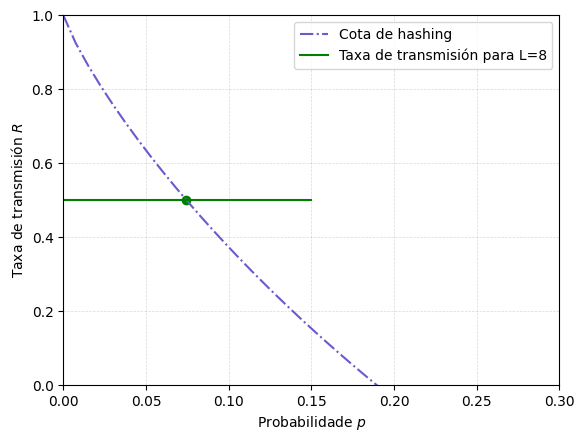

In [132]:
# rango x para a hashing bound
x = np.linspace(0.00001,0.75, 100)

# rango x para a taxa do código
x1 = np.linspace(0.000001, 0.15, 100)

# función de cotas de hashing
hashing = [hashing_bound(i) for i in x]
hashing_EA = [ea_hashing_bound(i) for i in x]

# función de taxas de transmisión dos códigos
codigo1 = [1-4/8 for i in x]
codigo1_ea = [1-2/8 for i in x]

# gráfica das cotas de hashing (liñas)
plt.plot(x, hashing, linestyle = '-.', color = 'slateblue', label='Cota de hashing')
plt.plot(x, hashing_EA, linestyle = '--', color = 'orange', label='Máxima cota de hashing EA')

# gráfica da cota de hashing (sombreada)
plt.fill_between(
    x, hashing, hashing_EA,
    where=(np.array(hashing_EA) >= np.array(hashing)),  # only fill when EA bound above normal
    color='orange', alpha=0.2, label='Cota de hashing EA'
)

# liña da taxa do código qLDPC
plt.plot(x1, codigo1, linestyle = '-', color = 'green', label = 'Taxa de transmisión para L=8')
plt.scatter(0.07438, 1-4/8, marker = 'o', color = 'green')

# liña da taxa do código EA-LDPC
plt.plot(x1, codigo1_ea, linestyle = '-', color = 'red', label = 'Taxa de transmisión EA para L=8')
plt.scatter(0.07438, 1-2/8, marker = 's', color = 'red')


plt.ylabel('Taxa de transmisión $R$')
plt.xlabel('Probabilidade $p$')
plt.axis((0,1,0,1))
plt.legend()
plt.xlim([0, 0.3])
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)
plt.show()


### FER

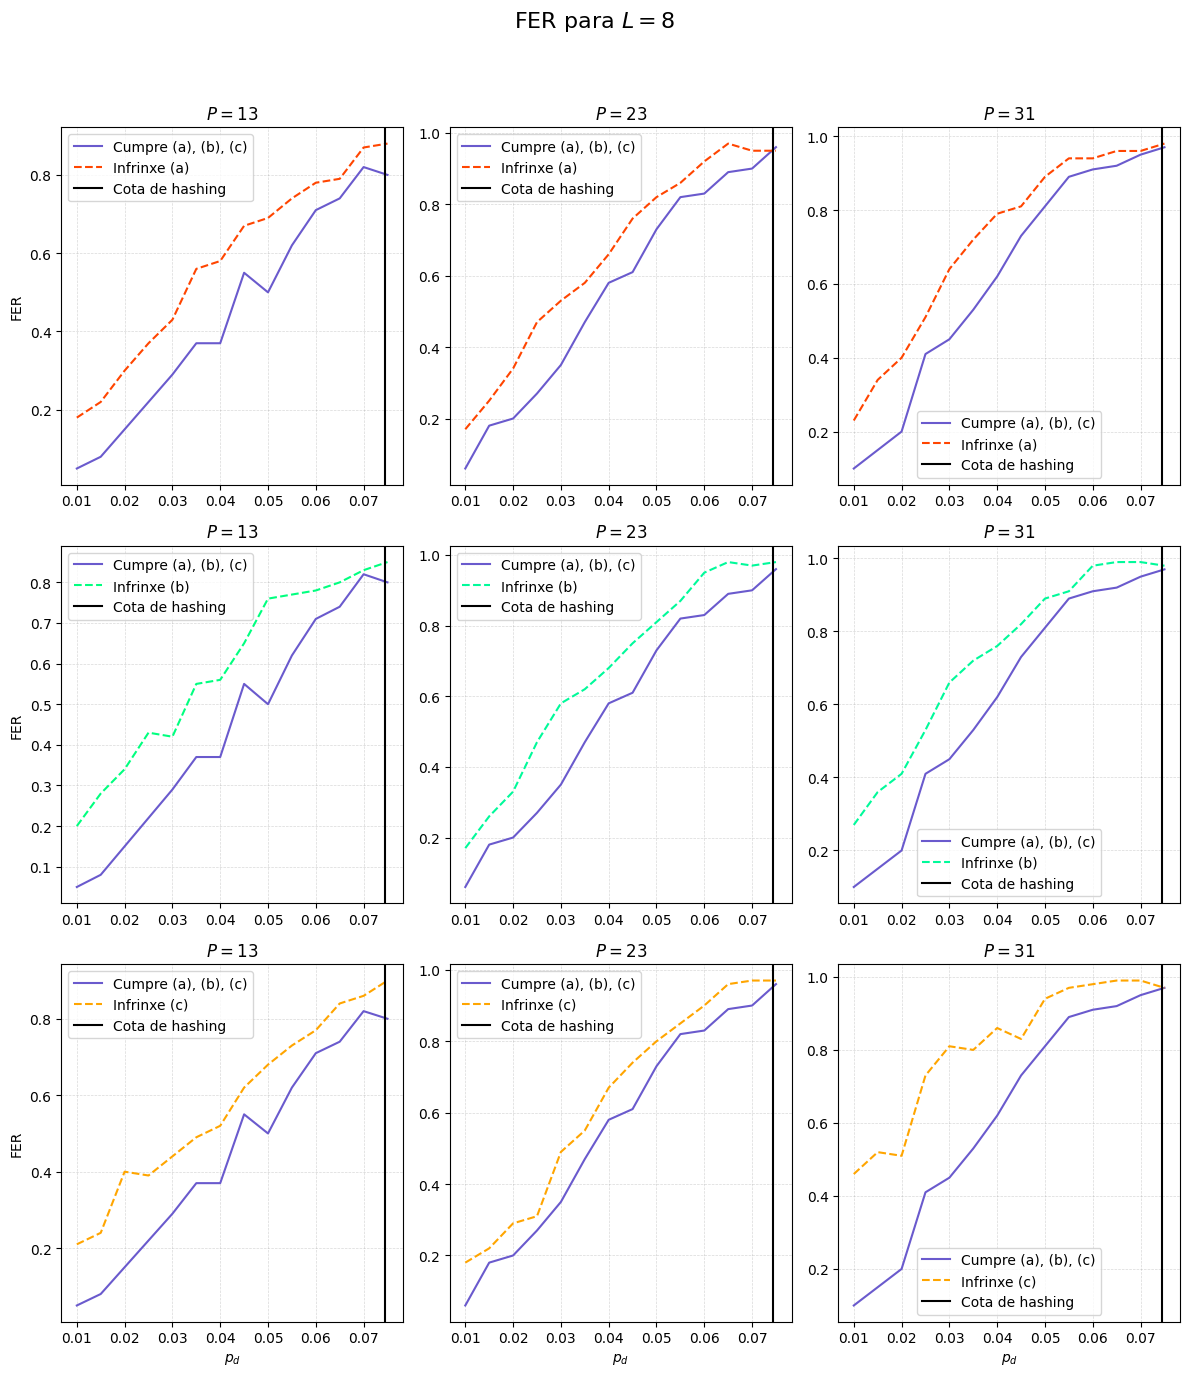

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# probabilidades no eixo x
px = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075]

# FER para P=13 
P13_bien = [0.05, 0.08, 0.15, 0.22, 0.29, 0.37, 0.37, 0.55, 0.5, 0.62, 0.71, 0.74, 0.82, 0.8]
P13_a    = [0.18, 0.22, 0.3, 0.37, 0.43, 0.56, 0.58, 0.67, 0.69, 0.74, 0.78, 0.79, 0.87, 0.88]
P13_b    = [0.2, 0.28, 0.34, 0.43, 0.42, 0.55, 0.56, 0.65, 0.76, 0.77, 0.78, 0.8, 0.83, 0.85]
P13_4c   = [0.21, 0.24, 0.4, 0.39, 0.44, 0.49, 0.52, 0.62, 0.68, 0.73, 0.77, 0.84, 0.86, 0.9]

# FER para P=23
P23_bien = [0.06, 0.18, 0.2, 0.27, 0.35, 0.47, 0.58, 0.61, 0.73, 0.82, 0.83, 0.89, 0.9, 0.96]
P23_a    = [0.17, 0.25, 0.34, 0.47, 0.53, 0.58, 0.66, 0.76, 0.82, 0.86, 0.92, 0.97, 0.95, 0.95]
P23_b    = [0.17, 0.26, 0.33, 0.47, 0.58, 0.62, 0.68, 0.75, 0.81, 0.87, 0.95, 0.98, 0.97, 0.98]
P23_4c   = [0.18, 0.22, 0.29, 0.31, 0.49, 0.55, 0.67, 0.74, 0.8, 0.85, 0.9, 0.96, 0.97, 0.97]

# FER para P=31
P31_bien = [0.1, 0.15, 0.2, 0.41, 0.45, 0.53, 0.62, 0.73, 0.81, 0.89, 0.91, 0.92, 0.95, 0.97]
P31_a    = [0.23, 0.34, 0.4, 0.51, 0.64, 0.72, 0.79, 0.81, 0.89, 0.94, 0.94, 0.96, 0.96, 0.98]
P31_b    = [0.27, 0.36, 0.41, 0.53, 0.66, 0.72, 0.76, 0.82, 0.89, 0.91, 0.98, 0.99, 0.99, 0.98]
P31_4c   = [0.46, 0.52, 0.51, 0.73, 0.81, 0.8, 0.86, 0.83, 0.94, 0.97, 0.98, 0.99, 0.99, 0.97]

# creación dos subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 14), sharex=True)

# Subplot P=13
axs[0, 0].plot(px, P13_bien, linestyle='-', color = 'slateblue', label='Cumpre (a), (b), (c)')
axs[0, 0].plot(px, P13_a, linestyle='--', color = 'orangered', label='Infrinxe (a)')
axs[0, 0].set_title('$P = 13$')
axs[0, 0].axvline(0.07438, color='black', linestyle='-', label='Cota de hashing')
axs[0, 0].legend()
axs[0, 0].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

axs[1, 0].plot(px, P13_bien, linestyle='-', color = 'slateblue', label='Cumpre (a), (b), (c)')
axs[1, 0].plot(px, P13_b, linestyle='--', color = 'springgreen', label='Infrinxe (b)')
axs[1, 0].set_title('$P = 13$')
axs[1, 0].axvline(0.07438, color='black', linestyle='-', label='Cota de hashing')
axs[1, 0].legend()
axs[1, 0].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

axs[2, 0].plot(px, P13_bien, linestyle='-', color = 'slateblue', label='Cumpre (a), (b), (c)')
axs[2, 0].plot(px, P13_4c, linestyle='--', color = 'orange', label='Infrinxe (c)')
axs[2, 0].set_title('$P = 13$')
axs[2, 0].axvline(0.07438, color='black', linestyle='-', label='Cota de hashing')
axs[2, 0].legend()
axs[2, 0].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

# Subplot P=23
axs[0, 1].plot(px, P23_bien, linestyle='-', color = 'slateblue', label='Cumpre (a), (b), (c)')
axs[0, 1].plot(px, P23_a, linestyle='--', color = 'orangered', label='Infrinxe (a)')
axs[0, 1].set_title('$P = 23$')
axs[0, 1].axvline(0.07438, color='black', linestyle='-', label='Cota de hashing')
axs[0, 1].legend()
axs[0, 1].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

axs[1, 1].plot(px, P23_bien, linestyle='-', color = 'slateblue', label='Cumpre (a), (b), (c)')
axs[1, 1].plot(px, P23_b, linestyle='--', color = 'mediumspringgreen', label='Infrinxe (b)')
axs[1, 1].set_title('$P = 23$')
axs[1, 1].axvline(0.07438, color='black', linestyle='-', label='Cota de hashing')
axs[1, 1].legend()
axs[1, 1].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

axs[2, 1].plot(px, P23_bien, linestyle='-', color = 'slateblue', label='Cumpre (a), (b), (c)')
axs[2, 1].plot(px, P23_4c, linestyle='--', color = 'orange', label='Infrinxe (c)')
axs[2, 1].set_title('$P = 23$')
axs[2, 1].axvline(0.07438, color='black', linestyle='-', label='Cota de hashing')
axs[2, 1].legend()
axs[2, 1].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

# Subplot P=31
axs[0, 2].plot(px, P31_bien, linestyle='-', color = 'slateblue', label='Cumpre (a), (b), (c)')
axs[0, 2].plot(px, P31_a, linestyle='--', color = 'orangered', label='Infrinxe (a)')
axs[0, 2].set_title('$P = 31$')
axs[0, 2].axvline(0.07438, color='black', linestyle='-', label='Cota de hashing')
axs[0, 2].legend()
axs[0, 2].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

axs[1, 2].plot(px, P31_bien, linestyle='-', color = 'slateblue', label='Cumpre (a), (b), (c)')
axs[1, 2].plot(px, P31_b, linestyle='--', color = 'mediumspringgreen', label='Infrinxe (b)')
axs[1, 2].set_title('$P = 31$')
axs[1, 2].axvline(0.07438, color='black', linestyle='-', label='Cota de hashing')
axs[1, 2].legend()
axs[1, 2].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

axs[2, 2].plot(px, P31_bien, linestyle='-', color = 'slateblue', label='Cumpre (a), (b), (c)')
axs[2, 2].plot(px, P31_4c, linestyle='--', color = 'orange', label='Infrinxe (c)')
axs[2, 2].set_title('$P = 31$')
axs[2, 2].axvline(0.07438, color='black', linestyle='-', label='Cota de hashing')
axs[2, 2].legend()
axs[2, 2].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)


# Formato dos eixos
for ax in axs.flat:
    ax.xaxis.set_major_locator(MaxNLocator(nbins=8)) 
    ax.tick_params(labelbottom=True) 
    ax.tick_params(labelleft=True)   

# ylabel só no exterior
for ax in axs[:, 0]:
    ax.set_ylabel("FER")

# xlabel só no exterior
for ax in axs[2, :]:
    ax.set_xlabel("$p_d$")


fig.suptitle('FER para $L=8$', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

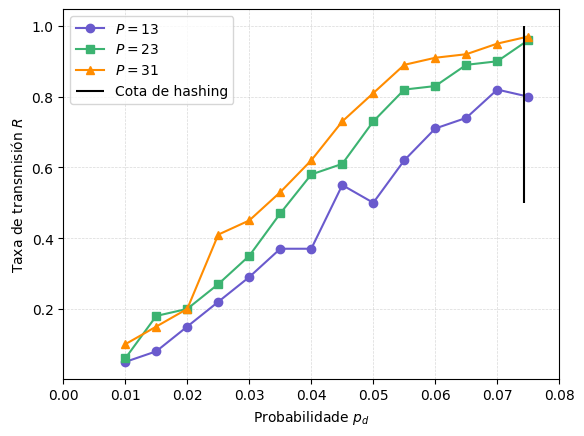

In [144]:
# probabilidades do eixo x
px = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075]

# valores do FER para P=13, 23, 31
P13_bien = [0.05, 0.08, 0.15, 0.22, 0.29, 0.37, 0.37, 0.55, 0.5, 0.62, 0.71, 0.74, 0.82, 0.8]
P23_bien = [0.06, 0.18, 0.2, 0.27, 0.35, 0.47, 0.58, 0.61, 0.73, 0.82, 0.83, 0.89, 0.9, 0.96]
P31_bien = [0.1, 0.15, 0.2, 0.41, 0.45, 0.53, 0.62, 0.73, 0.81, 0.89, 0.91, 0.92, 0.95, 0.97]

plt.plot(px, P13_bien, linestyle='-', marker = 'o', color = 'slateblue', label='$P=13$')
plt.plot(px, P23_bien, linestyle='-', marker = 's', color = 'mediumseagreen', label='$P=23$')
plt.plot(px, P31_bien, linestyle='-', marker = '^', color = 'darkorange', label='$P=31$')

# liña da cota de hashing
plt.vlines(0.07438, 0.5, 1, color='black', linestyle='-', label='Cota de hashing')

plt.ylabel('Taxa de transmisión $R$')
plt.xlabel('Probabilidade $p_d$')
plt.xlim([0, 0.08])
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)
plt.show()